In [1]:
import os
from arcgis.gis import GIS
from arcgis.env import active_gis
from arcgis.features import GeoAccessor
from arcgis.geocoding import geocode
from arcgis.geometry import Geometry, filters
from arcgis import geoenrichment
import pandas as pd
import numpy as np
import json
import arcpy
import uuid

import sys
sys.path.append('../src/geoai_retail')
import utils
import config
import proximity_rest as proximity

arcpy.env.overwriteOutput = True

gis = GIS(config.ent_url, username=config.ent_user, password=config.ent_pass)
gis

%load_ext autoreload
%autoreload 2

In [2]:
prospective_coffee_id = 'd14a10b3178244e691075dd0e8586a40'
coffee_id = 'e88a172f437b41d1babf9b21c934bee0'
block_id = 'a00ffb550b1342cd86ce89d0d95224e4'
closest_csv = '../data/interim/closest_table.csv'
demographic_csv = '../data/raw/blocks_enriched.csv'

<Item title:"coffee_pdx" type:Feature Layer Collection owner:jmccune>
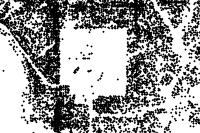

In [3]:
# Item Added From Toolbar
# Title: coffee_pdx | Type: Feature Service | Owner: jmccune
coffee_itm = gis.content.get(coffee_id)
coffee_itm

In [22]:
coffee_lyr = gis.content.get("e88a172f437b41d1babf9b21c934bee0").layers[0]
coffee_df = coffee_lyr.query(out_sr=4326, as_df=True)
coffee_df.locnum = coffee_df.locnum.astype('int64')
coffee_df.head()

,SHAPE,city,coname,empnum,frncod,hdbrch,iscode,loc_name,locnum,naics,...,sic,source,sqftcode,state,state_name,status,street,ultnum,zip,zip4
0,"{""x"": -122.9927000000911, ""y"": 44.776100000081...",JEFFERSON,SNOW PEAK COFFEE CO,3.0,,,,PointAddress,413963145,72251505,...,581228,INFOGROUP,1,OR,Oregon,M,HILLWOOD RD SE,000000000,97352,9212
1,"{""x"": -122.96480000002941, ""y"": 44.79579999955...",TURNER,BAD GIRLS COFFEE,4.0,,,,PointAddress,422168012,72251505,...,581228,INFOGROUP,1,OR,Oregon,M,PARRISH GAP RD SE,000000000,97392,9565
2,"{""x"": -123.3156000002964, ""y"": 44.924600000357...",DALLAS,DUTCH BROTHERS COFFEE,10.0,Y,2,,PointAddress,244210043,72251505,...,581228,INFOGROUP,2,OR,Oregon,M,SE JEFFERSON ST,692438138,97338,2023
3,"{""x"": -123.30960000069845, ""y"": 44.92999999937...",DALLAS,STARBUCKS,13.0,4,2,,PointAddress,396819021,72251505,...,581228,INFOGROUP,2,OR,Oregon,M,E ELLENDALE AVE,303651459,97338,1523
4,"{""x"": -123.31230000047263, ""y"": 44.93040000040...",DALLAS,STARBUCKS,15.0,4,2,,PointAddress,396819062,72251505,...,581228,INFOGROUP,2,OR,Oregon,M,W ELLENDALE AVE,303651459,97338,1408


In [24]:
coffee_df = coffee_df[['locnum', 'coname', 'SHAPE']].copy()
coffee_df.columns = ['dest_id', 'dest_name', 'SHAPE']
coffee_df.head()

,dest_id,dest_name,SHAPE
0,413963145,SNOW PEAK COFFEE CO,"{""x"": -122.9927000000911, ""y"": 44.776100000081..."
1,422168012,BAD GIRLS COFFEE,"{""x"": -122.96480000002941, ""y"": 44.79579999955..."
2,244210043,DUTCH BROTHERS COFFEE,"{""x"": -123.3156000002964, ""y"": 44.924600000357..."
3,396819021,STARBUCKS,"{""x"": -123.30960000069845, ""y"": 44.92999999937..."
4,396819062,STARBUCKS,"{""x"": -123.31230000047263, ""y"": 44.93040000040..."


In [25]:
coffee_name_cnt = coffee_df.groupby('dest_name').count().iloc[:,0].sort_values(ascending=False).to_frame()
coffee_name_cnt.columns = ['count']
coffee_name_cnt.reset_index(inplace=True)

coffee_name_cnt['dest_name_category'] = coffee_name_cnt.apply(lambda r: 'INDEPENDENT' if r['count'] <= 1 else r['dest_name'], axis=1)
coffee_name_cnt.set_index('dest_name', inplace=True, drop=True)

coffee_name_cnt.head(25)

,count,dest_name_category
dest_name,,
STARBUCKS,298,STARBUCKS
DUTCH BROTHERS COFFEE,49,DUTCH BROTHERS COFFEE
UNCLE GARY'S COFFEE EMPORIUM,15,UNCLE GARY'S COFFEE EMPORIUM
ALLEGRO COFFEE,7,ALLEGRO COFFEE
HUMAN BEAN,7,HUMAN BEAN
BLACK ROCK COFFEE BAR,6,BLACK ROCK COFFEE BAR
STUMPTOWN COFFEE ROASTERS,4,STUMPTOWN COFFEE ROASTERS
CITY COFFEE,4,CITY COFFEE
BLACK ROCK COFFEE,3,BLACK ROCK COFFEE


In [28]:
coffee_df = utils.add_store_name_category(coffee_df, 'dest_name')
coffee_df.head()

,dest_id,dest_name,SHAPE,dest_name_category
0,413963145,SNOW PEAK COFFEE CO,"{""x"": -122.9927000000911, ""y"": 44.776100000081...",INDEPENDENT
1,422168012,BAD GIRLS COFFEE,"{""x"": -122.96480000002941, ""y"": 44.79579999955...",INDEPENDENT
2,244210043,DUTCH BROTHERS COFFEE,"{""x"": -123.3156000002964, ""y"": 44.924600000357...",DUTCH BROTHERS COFFEE
3,396819021,STARBUCKS,"{""x"": -123.30960000069845, ""y"": 44.92999999937...",STARBUCKS
4,396819062,STARBUCKS,"{""x"": -123.31230000047263, ""y"": 44.93040000040...",STARBUCKS


<Item title:"prospective_pdx_coffee" type:Feature Layer Collection owner:jmccune>
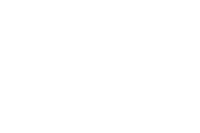

In [29]:
prospective_coffee_itm = gis.content.get(prospective_coffee_id)
prospective_coffee_itm

In [30]:
prospective_coffee_df = prospective_coffee_itm.layers[0].query(out_sr=4326, as_df=True)
prospective_coffee_df

,SHAPE,created_date,created_user,globalid,id,last_edited_date,last_edited_user,objectid
0,"{""x"": -122.6950004421445, ""y"": 45.577250341602...",2019-06-28 04:07:53,jmccune,{72DFA213-AD6F-43ED-97D5-7C9055241EA0},None,2019-06-28 04:07:53,jmccune,1
1,"{""x"": -122.49475770710183, ""y"": 45.39444317343...",2019-06-28 04:24:47,jmccune,{CC6F6301-3344-4A19-AB3C-73438C34EC9F},None,2019-06-28 04:24:47,jmccune,2


In [31]:
prospective_id_fld = 'objectid'

prospective_coffee_df = prospective_coffee_df[[prospective_id_fld, 'SHAPE']].copy()
prospective_coffee_df['dest_name'] = 'PROSPECTIVE'
prospective_coffee_df['dest_name_category'] = 'INDEPENDENT'
prospective_coffee_df.columns = ['dest_id', 'SHAPE', 'dest_name', 'dest_name_category']
prospective_coffee_df

,dest_id,SHAPE,dest_name,dest_name_category
0,1,"{""x"": -122.6950004421445, ""y"": 45.577250341602...",PROSPECTIVE,INDEPENDENT
1,2,"{""x"": -122.49475770710183, ""y"": 45.39444317343...",PROSPECTIVE,INDEPENDENT


In [32]:
closest_existing_df = proximity.closest_dataframe_from_origins_destinations(
    prospective_coffee_df, 'dest_id',  
    coffee_df, 'dest_id', 
    gis)
closest_existing_df.set_index('origin_id', inplace=True)
closest_existing_df

Location "411960623" in "Facilities" is on a soft-restricted network element.
Location "521171819" in "Facilities" is on a soft-restricted network element.



,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,proximity_kilometers_04,proximity_minutes_04
origin_id,,,,,,,,,,,,
1,427295695,1.159041,2.316634,637497264,1.249904,3.036825,722716448,1.291021,4.875373,415522511,1.791345,6.188322
2,238078257,4.529454,6.866351,652026907,4.789013,6.591055,637457979,5.414723,7.453672,725656465,5.493895,6.697960


In [33]:
study_loc_id = 1

# select the destionation_id's matching to any of the destinations close to the prospective location above
destination_cols = [col for col in closest_existing_df.columns if col.startswith('destination_id_')]
destination_cols

['destination_id_01',
 'destination_id_02',
 'destination_id_03',
 'destination_id_04']

In [34]:
existing_id_lst = [int(val) for val in closest_existing_df.iloc[1][destination_cols].values]
existing_id_lst

[238078257, 652026907, 637457979, 725656465]

In [35]:
# load the od table
closest_df = pd.read_csv(closest_csv, index_col=0)

closest_df.head()

,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,proximity_kilometers_04,proximity_minutes_04
0,410050201001000,998326755,1.548381,3.355589,236771176,1.716985,3.834511,731023672,1.776342,3.778623,895875482,1.880792,4.141975
1,410050201001001,998326755,1.358351,2.816526,236771176,1.526954,3.295449,731023672,1.586312,3.239560,895875482,1.690762,3.602913
2,410050201001002,998326755,1.683183,3.781076,236771176,1.851786,4.259999,731023672,1.911143,4.204111,895875482,2.015593,4.567463
3,410050201001003,998326755,1.480122,3.140135,236771176,1.648726,3.619058,731023672,1.708083,3.563170,895875482,1.812533,3.926522
4,410050201001004,998326755,1.577137,2.642447,236771176,1.745741,3.121370,731023672,1.805098,3.065482,895875482,1.909548,3.428834


In [36]:
# select the existing store locations matching to any of the listed destinations for a location and put this subset in a dataframe
closest_df = closest_df[closest_df['destination_id_01'].isin(existing_id_lst)]
print(f'block count - {len(closest_df.index):,}\n')

block count - 523



In [37]:
existing_coffee_df = coffee_df[coffee_df['dest_id'].isin(existing_id_lst)]
existing_coffee_df.set_index('dest_id', inplace=True)
existing_coffee_df

,dest_name,SHAPE,dest_name_category
dest_id,,,
238078257,STARBUCKS,"{""x"": -122.51339999952711, ""y"": 45.42539999973...",STARBUCKS
637457979,STARBUCKS,"{""x"": -122.45589999971226, ""y"": 45.41849999945...",STARBUCKS
652026907,UNCLE GARY'S COFFEE EMPORIUM,"{""x"": -122.49969999974154, ""y"": 45.42739999990...",UNCLE GARY'S COFFEE EMPORIUM
725656465,JIM & PATTY'S COFFEE,"{""x"": -122.48949999979624, ""y"": 45.42710000001...",JIM & PATTY'S COFFEE


In [38]:
# add the prospective location to the subset store dataframe
prospective_coffee_df = existing_coffee_df.append(prospective_coffee_df.iloc[study_loc_id][['coname', 'SHAPE']])
prospective_coffee_df.reset_index(inplace=True)
prospective_coffee_df

,dest_id,dest_name,SHAPE,dest_name_category,coname
0,238078257,STARBUCKS,"{'x': -122.51339999952711, 'y': 45.42539999973...",STARBUCKS,NaN
1,637457979,STARBUCKS,"{'x': -122.45589999971226, 'y': 45.41849999945...",STARBUCKS,NaN
2,652026907,UNCLE GARY'S COFFEE EMPORIUM,"{'x': -122.49969999974154, 'y': 45.42739999990...",UNCLE GARY'S COFFEE EMPORIUM,NaN
3,725656465,JIM & PATTY'S COFFEE,"{'x': -122.48949999979624, 'y': 45.42710000001...",JIM & PATTY'S COFFEE,NaN
4,1,NaN,"{'x': -122.49475770710183, 'y': 45.39444317343...",NaN,NaN


<Item title:"blocks" type:Feature Layer Collection owner:jmccune>
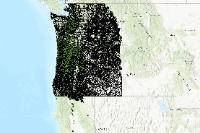

In [39]:
# select the blocks with the origin_id's identified - query using the centroid option and put the result in a dataframe
block_itm = gis.content.get(block_id)
block_itm

In [40]:
where_clause = ' OR '.join([f"geoid = '{oid}'" for oid in closest_df['origin_id'].values])
where_clause[:120]

"geoid = '410050221031000' OR geoid = '410050221031001' OR geoid = '410050221031002' OR geoid = '410050221031003' OR geoi"

In [41]:
block_lyr = block_itm.layers[0]
block_df = block_lyr.query(where_clause, out_sr=4326, as_df=True)
block_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 9 columns):
SHAPE       523 non-null geometry
aland       523 non-null float64
awater      523 non-null float64
geoid       523 non-null object
intptlat    523 non-null object
intptlon    523 non-null object
name        523 non-null object
objectid    523 non-null int64
suffix      0 non-null object
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 36.9+ KB


In [42]:
prospective_closest_df = proximity.closest_dataframe_from_origins_destinations(block_df, 'geoid', prospective_coffee_df, 'dest_id', gis)
prospective_closest_df.head()

Location "410050221031016" in "Incidents" is on a soft-restricted network element.
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Avoid Private Roads").



,origin_id,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,proximity_kilometers_04,proximity_minutes_04
0,410050221031017,238078257,0.629563,2.116377,652026907,1.683828,3.892793,725656465,2.388710,3.999698,1,4.478970,5.379200
1,410050221031000,238078257,0.335459,1.380310,652026907,1.389724,3.156726,725656465,2.094607,3.263631,1,4.454240,6.864297
2,410050221031001,238078257,0.571191,1.937757,652026907,1.289825,3.512987,725656465,1.994707,3.619892,1,4.120826,5.598710
3,410050221031002,238078257,0.247044,0.950727,652026907,1.301309,2.727143,725656465,2.006191,2.834048,1,4.416205,6.610728
4,410050221031003,238078257,0.360009,0.656370,652026907,1.414274,2.432786,725656465,2.119156,2.539691,1,4.634076,7.455426


In [43]:
demographic_df = pd.read_csv(demographic_csv)
demographic_df.drop(columns=['OBJECTID', 'Shape_Length', 'Shape_Area'], inplace=True, axis=1)
demographic_df.set_index('GEOID', inplace=True)

print(f'Loaded {len(demographic_df.columns):,} demographic factors for {len(demographic_df.index):,} geographies.')
demographic_df.head()

Loaded 1,208 demographic factors for 64,930 geographies.


,groupquarters_gqpop_cy,generations_genalphacy,generations_genz_cy,generations_millenn_cy,generations_genx_cy,generations_babyboomcy,generations_oldrgenscy,generations_genbase_cy,gender_pop0_cy,gender_pop5_cy,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
GEOID,,,,,,,,,,,,,,,,,,,,,
410710303014029,0.0,2.0,21.0,18.0,21.0,20.0,6.0,88.0,5.0,6.0,...,5.0,5.0,0.0,3.0,2.0,1.0,1.0,1.0,0.0,59.0
410710303014030,0.0,3.0,26.0,22.0,26.0,25.0,7.0,108.0,6.0,7.0,...,6.0,6.0,0.0,3.0,3.0,1.0,2.0,2.0,0.0,72.0
410710303014031,0.0,1.0,6.0,5.0,6.0,6.0,2.0,27.0,2.0,2.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,18.0
410710303014032,0.0,4.0,35.0,29.0,35.0,34.0,9.0,145.0,8.0,10.0,...,8.0,8.0,0.0,4.0,3.0,1.0,2.0,2.0,0.0,97.0
410710303014033,0.0,1.0,10.0,9.0,10.0,10.0,3.0,43.0,3.0,3.0,...,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,29.0


In [44]:
combined_df = prospective_closest_df.join(demographic_df, on='origin_id')
combined_df.set_index('origin_id', inplace=True, drop=True)
combined_df.head()

,destination_id_01,proximity_kilometers_01,proximity_minutes_01,destination_id_02,proximity_kilometers_02,proximity_minutes_02,destination_id_03,proximity_kilometers_03,proximity_minutes_03,destination_id_04,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
origin_id,,,,,,,,,,,,,,,,,,,,,
410050221031017,238078257,0.629563,2.116377,652026907,1.683828,3.892793,725656465,2.388710,3.999698,1,...,5.0,3.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,38.0
410050221031000,238078257,0.335459,1.380310,652026907,1.389724,3.156726,725656465,2.094607,3.263631,1,...,5.0,4.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,42.0
410050221031001,238078257,0.571191,1.937757,652026907,1.289825,3.512987,725656465,1.994707,3.619892,1,...,4.0,3.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,37.0
410050221031002,238078257,0.247044,0.950727,652026907,1.301309,2.727143,725656465,2.006191,2.834048,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410050221031003,238078257,0.360009,0.656370,652026907,1.414274,2.432786,725656465,2.119156,2.539691,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
factor_cols = [col for col in combined_df.columns if not col.startswith('destination_id')]
X = combined_df[factor_cols]
X.head()

,proximity_kilometers_01,proximity_minutes_01,proximity_kilometers_02,proximity_minutes_02,proximity_kilometers_03,proximity_minutes_03,proximity_kilometers_04,proximity_minutes_04,groupquarters_gqpop_cy,generations_genalphacy,...,schoolenrollment_acsgrd9,schoolenrollment_acspubgrd9,schoolenrollment_acsprvgrd9,schoolenrollment_acscollege,schoolenrollment_acspubcoll,schoolenrollment_acsprvcoll,schoolenrollment_acsgrad,schoolenrollment_acspubgrad,schoolenrollment_acsprvgrad,schoolenrollment_acsnotnsch
origin_id,,,,,,,,,,,,,,,,,,,,,
410050221031017,0.629563,2.116377,1.683828,3.892793,2.388710,3.999698,4.478970,5.379200,0.0,1.0,...,5.0,3.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,38.0
410050221031000,0.335459,1.380310,1.389724,3.156726,2.094607,3.263631,4.454240,6.864297,0.0,2.0,...,5.0,4.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,42.0
410050221031001,0.571191,1.937757,1.289825,3.512987,1.994707,3.619892,4.120826,5.598710,0.0,1.0,...,4.0,3.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,37.0
410050221031002,0.247044,0.950727,1.301309,2.727143,2.006191,2.834048,4.416205,6.610728,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410050221031003,0.360009,0.656370,1.414274,2.432786,2.119156,2.539691,4.634076,7.455426,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
